This notebook largely follows the one I created in class on 9/9/2020, at least through the answer to question 1.

Let's start by loading our packages:
- Pandas for dataframes, etc.
- Numpy for basic math functions
- Matplotlib for plotting functionality
- Statsmodels for regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf

Here are some parameters:

In [2]:
first_date = '1950-01-01'
last_date  = '2020-06-30'
ma_length  = 10

We're going to read in raw data on the so-called Fama-French factors.

After specifying the file name, I tell read_csv to skip the first four lines of the CSV file, which contain header information.  I then tell it to give names of my choice to the five columns of numbers that follow the header rows.

In [3]:
ffdata = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=4, names=['Date','RMRF','SMB','HML','RF'])
ffdata.head()

,Date,RMRF,SMB,HML,RF
0,192607,2.96,-2.30,-2.87,0.22
1,192608,2.64,-1.40,4.19,0.25
2,192609,0.36,-1.32,0.01,0.23
3,192610,-3.24,0.04,0.51,0.32
4,192611,2.53,-0.20,-0.35,0.31


You can see that the dates are in "YYYYMM" format.  To convert to month end datetime values and then use these as the index, we do the following:

In [4]:
ffdata['Date'] = pd.to_datetime(ffdata['Date'], format='%Y%m') + MonthEnd(1)
ffdata = ffdata.set_index('Date')
ffdata.tail()

,RMRF,SMB,HML,RF
Date,,,,
2020-04-30,13.65,2.78,-1.27,0.00
2020-05-31,5.58,2.47,-4.95,0.01
2020-06-30,2.45,2.56,-2.03,0.01
2020-07-31,5.51,-999.00,-999.00,0.01
2020-08-31,7.01,-999.00,-999.00,0.01


Let's just keep the more recent part of the sample:

In [5]:
ffdata=ffdata.loc[first_date:last_date]
ffdata.head()

,RMRF,SMB,HML,RF
Date,,,,
1950-01-31,1.70,3.36,0.14,0.09
1950-02-28,1.48,0.04,-0.81,0.09
1950-03-31,1.26,-1.41,-2.77,0.10
1950-04-30,3.94,1.99,1.34,0.09
1950-05-31,4.31,-2.12,0.46,0.10


The last data munging step is to convert the (obviously) percentile returns into decimals:

In [6]:
ffdata = ffdata / 100
ffdata.tail()

,RMRF,SMB,HML,RF
Date,,,,
2020-02-29,-0.0813,0.0096,-0.0401,0.0012
2020-03-31,-0.1339,-0.0516,-0.1412,0.0012
2020-04-30,0.1365,0.0278,-0.0127,0.0000
2020-05-31,0.0558,0.0247,-0.0495,0.0001
2020-06-30,0.0245,0.0256,-0.0203,0.0001


To go any further, we need to know what the data represent and what we are trying to do with them.  

RMRF is the excess return on the market, or the return on the market minus the risk-free return:
$$ RMRF = RM - RF $$
If we want to compute a market return (not in excess of RF) we simply add the RMRF and RF columns.

The goal will be to examine a simple technical trading indicator, the 10-month MA crossover.  The strategy is to buy when the level of an index exceeds its 10-month MA.  Otherwise, you hold the risk-free asset.  See the paper by Faber.

An index is a price.  We have returns.  Since $R_t = P_t / P_{t-1} - 1$, we can recover a price level by rewriting the relation as $P_t = P_{t-1} \times (1+R_t)$.  

If we plug that last equation into itself, we can say that 

$P_t = P_{t-1} \times (1+R_t) = P_t = [ P_{t-2} \times (1+R_{t-1}) ] \times (1+R_t)$

Continuing back to date 0,

$P_t = P_0 \times (1+R_1) \times (1+R_2) \times ... \times (1+R_t)$

It is harmless to set $P_0=1$, because this will not change _relative_ prices, so that's what we'll do.

To carry this out, start by creating a column of returns (since RMRF is the excess return):

In [7]:
ffdata['RM']=ffdata['RMRF']+ffdata['RF']

Now add 1 to compute the "gross return"

In [8]:
ffdata['GRM']=ffdata['RM']+1

The index level is just the cumulative product of gross returns:

In [9]:
ffdata['M']=ffdata['GRM'].cumprod()

Alternatively, we could just compute the M column in one step:

In [10]:
ffdata['M']=(ffdata['RMRF'] + ffdata['RF'] + 1).cumprod()

Now let's define the moving average, where the length was specified up top.  To do so we use the rolling method, which is a method to perform calculations on rolling subsections of rows of a dataframe.  It is a method that requires another method to produce output.  In this case we want to compute a rolling mean.  The syntax is therefore

In [11]:
ffdata['MA']=ffdata['M'].rolling(ma_length).mean()
ffdata.head(15)

,RMRF,SMB,HML,RF,RM,GRM,M,MA
Date,,,,,,,,
1950-01-31,0.0170,0.0336,0.0014,0.0009,0.0179,1.0179,1.017900,NaN
1950-02-28,0.0148,0.0004,-0.0081,0.0009,0.0157,1.0157,1.033881,NaN
1950-03-31,0.0126,-0.0141,-0.0277,0.0010,0.0136,1.0136,1.047942,NaN
1950-04-30,0.0394,0.0199,0.0134,0.0009,0.0403,1.0403,1.090174,NaN
1950-05-31,0.0431,-0.0212,0.0046,0.0010,0.0441,1.0441,1.138251,NaN
1950-06-30,-0.0594,-0.0238,-0.0078,0.0010,-0.0584,0.9416,1.071777,NaN
1950-07-31,0.0136,0.0051,0.1366,0.0010,0.0146,1.0146,1.087425,NaN
1950-08-31,0.0485,0.0073,-0.0141,0.0010,0.0495,1.0495,1.141252,NaN
1950-09-30,0.0481,0.0057,-0.0111,0.0010,0.0491,1.0491,1.197288,NaN


We want to put 100% in the market when the lagged market index (M) exceeds the moving average (MA) and zero otherwise.

We lag data using the shift method:

In [12]:
ffdata['weight']=np.nan
ffdata.loc[ffdata['M'].shift(1) > ffdata['MA'].shift(1), 'weight'] = 1
ffdata.loc[ffdata['M'].shift(1) <= ffdata['MA'].shift(1), 'weight'] = 0

Now we can compute the excess return on the managed portfolio (P).

The return (not excess) on the managed portfolio is 
$$RP = weight \times RM + (1-weight) \times RF = RF + weight \times (RM - RF) $$
The excess return on the managed portfolio is therefore simply
$$RPRF = weight \times RMRF $$


In [13]:
ffdata['RPRF']=ffdata['weight']*ffdata['RMRF']

Let's get rid of all rows with missing values so we are comparing RMRF (which has no missing values) to RP (which does have missing values) in a fair way.

In [14]:
ffdata.dropna(inplace=True)
ffdata.head()

,RMRF,SMB,HML,RF,RM,GRM,M,MA,weight,RPRF
Date,,,,,,,,,,
1950-11-30,0.0276,-0.0084,0.0317,0.0011,0.0287,1.0287,1.230911,1.123547,1.0,0.0276
1950-12-31,0.0554,0.0149,0.0723,0.0011,0.0565,1.0565,1.300457,1.150204,1.0,0.0554
1951-01-31,0.0570,0.0173,0.0372,0.0013,0.0583,1.0583,1.376274,1.183038,1.0,0.0570
1951-02-28,0.0141,0.0009,-0.0283,0.0010,0.0151,1.0151,1.397056,1.213726,1.0,0.0141
1951-03-31,-0.0215,-0.0064,-0.0422,0.0011,-0.0204,0.9796,1.368556,1.236756,1.0,-0.0215


Let's take a look at the growth of the timing portfolio relative to the market.  I will use the cumprod method again.  

When plotting here, I will specify colors.  I'll also use a log scale for the y axis, which makes the earlier part of the figure easier to see.

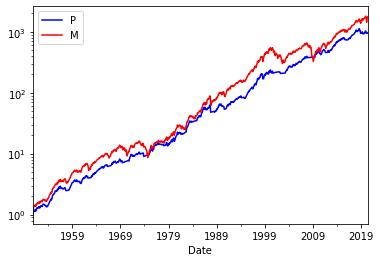

In [15]:
ffdata['P']=(ffdata['RPRF']+ffdata['RF']+1).cumprod()
ffdata['P'].plot(logy=True, color='b')
ffdata['M'].plot(logy=True, color='r')
plt.legend()
plt.show()

Let's look to see how thinks look over the last five years.  I start by using tail to take the last five years of data, but I then have to divide by the starting level of each portfolio value so that I am looking at the growth of $1 starting five years ago.

C:\Users\msft\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\msft\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


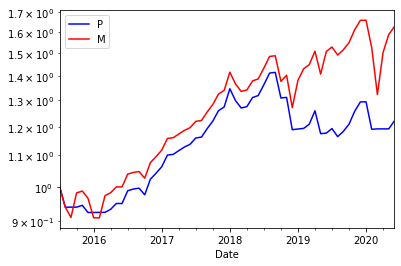

In [16]:
last5y = ffdata.tail(60)
last5y['P'] = last5y['P'] / last5y['P'].iloc[0]
last5y['M'] = last5y['M'] / last5y['M'].iloc[0]
last5y['P'].plot(logy=True, color='b')
last5y['M'].plot(logy=True, color='r')
plt.legend()
plt.show()

That's question 1.  Let's turn now to question 2.  The regression we want to run is 
$$ r_{m,t} - r_{f,t} = a + b \times \mbox{weight}_t + \epsilon_t $$
Note that the independent variable, weight, is not lagged in this regression.  That is because I have defined the time $t$ weight to depend on the time $t-1$ price and moving average.  So this regression is "predictive" in that I am using time $t-1$ information to predict returns in time $t$.

The parameter of interest in this regression is $b$.  This is because $b$ measures the impact that the weight has on expected returns.  If this impact is significant, it indicates that returns can be predicted.  After all, predictability just means that a change in a variable you know before you invest (weight) changes your prediction of the subsequent rate of return.  That's exactly what $b$ measures.

In [17]:
results = smf.ols('RMRF ~ weight', data=ffdata).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   RMRF   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.018
Date:                Mon, 14 Sep 2020   Prob (F-statistic):              0.313
Time:                        13:07:31   Log-Likelihood:                 1445.4
No. Observations:                 836   AIC:                            -2887.
Df Residuals:                     834   BIC:                            -2877.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0037      0.003      1.222      0.2

The coefficient on weight is positive, but with a t-statistic under 2 it is insignificant.  That tells me that the Faber strategy does not have a strong statistical justification.  

Moving on to question 3, we're going to start working with the HML column of the dataframe.  This column contains the excess returns on a portfolio that goes long value stocks (High book-to-market ratios) and goes short growth stocks (Low book-to-market).

This portfolio, which is often called "value minus growth", is really 100% long value (H for high B/P), 100% short growth (L for low B/P), and 100% long risk-free.  The weights add up to 1, and the return is equal to 
$$ 1 \times R_H - 1 \times R_L + 1 \times R_F $$

The HML column in our dataframe measures the excess return, which is $R_H - R_L$.  We can therefore write this return as

ffdata['HML'] + ffdata['RF'].

We'll compute this return and use cumprod to convert returns into portfolio values:

In [18]:
ffdata['HML portval'] = (1 + ffdata['HML'] + ffdata['RF']).cumprod()

As in Faber's paper, we will choose a portfolio weight based on whether this portfolio value is above or below the 10-month moving average, and I will go long the HML portfolio when it is above it.

Differently from Faber, I will short HML when the portfolio is below the MA.  When I do this, I will be buying growth stocks and shorting value stocks. 

In [19]:
ffdata['HML MA'] = ffdata['HML portval'].rolling(ma_length).mean()

ffdata['HML weight'] = 0
ffdata.loc[ffdata['HML portval'].shift(1) > ffdata['HML MA'].shift(1), 'HML weight'] = 1
ffdata.loc[ffdata['HML portval'].shift(1) < ffdata['HML MA'].shift(1), 'HML weight'] = -1

Excess returns on the timing strategy are

In [20]:
ffdata['HML_timing']=ffdata['HML weight']*ffdata['HML']

To compare the plain HML strategy with the timing HML strategy, we compute some basic summary statistics:

In [21]:
stats = ffdata[['HML','HML_timing']].describe()
stats

,HML,HML_timing
count,836.000000,836.000000
mean,0.002607,0.004288
std,0.027280,0.026768
min,-0.141200,-0.099900
25%,-0.012200,-0.009625
50%,0.001800,0.003350
75%,0.016900,0.017550
max,0.128700,0.141200


Annualized sharpe ratios are therefore

In [22]:
stats.loc['mean'] / stats.loc['std'] * np.sqrt(12)

HML           0.331081
HML_timing    0.554860
dtype: float64

The timing strategy works well.  Let's look at its alpha:

In [23]:
results = smf.ols('HML_timing ~ RMRF', data=ffdata).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             HML_timing   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     33.63
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           9.44e-09
Time:                        13:07:31   Log-Likelihood:                 1857.6
No. Observations:                 836   AIC:                            -3711.
Df Residuals:                     834   BIC:                            -3702.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0051      0.001      5.512      0.0

A 51 basis point per month alpha is not bad.  And it is _highly_ significant.  

Let's compare to the plain HML strategy:

In [24]:
results = smf.ols('HML ~ RMRF', data=ffdata).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    HML   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     27.95
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           1.59e-07
Time:                        13:07:31   Log-Likelihood:                 1839.0
No. Observations:                 836   AIC:                            -3674.
Df Residuals:                     834   BIC:                            -3665.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0033      0.001      3.545      0.0

Plain HML is good, but not as good as HML with timing.

Last, let's look at the performance of the two strategies over time:

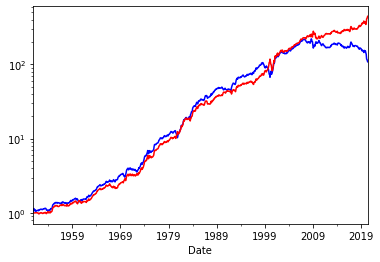

In [25]:
(ffdata['HML']+ffdata['RF']+1).cumprod().plot(logy=True, color='b')
(ffdata['HML_timing']+ffdata['RF']+1).cumprod().plot(logy=True, color='r')
plt.show()

The big result seems to be that the HML with timing strategy does well in the last decade, when it goes long growth stocks.  It therefore avoided the terrible performance of value over this period and benefitted from the rise of growth stocks (like FANG stocks).